<a href="https://colab.research.google.com/github/ameyas1/face_age_race_gender/blob/master/face_age_race_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 94% 311M/331M [00:02<00:00, 165MB/s]
100% 331M/331M [00:02<00:00, 163MB/s]


In [3]:
!unzip -q /content/utkface-new.zip 

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def age_group(age):
    if age >=0 and age <= 2:
        return 0
    elif age <= 39:
        return 1
    elif age <= 59:
        return 2
    else:
        return 3

In [7]:
age_dict={0:"Baby(0-2)",1:"Young Adults(3-39)",2:"Middle Aged Adults(40-59)",3:"Old Adults(60-inf)" }
gender_dict={0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [8]:
def read_data(base_path):
        image_list = []
        age_list = []
        gender_list = []
        race_list=[]
#         label_map_dict = {}
        
#         count_label = 0

        for class_name in os.listdir(base_path):
            class_path = os.path.join(base_path, class_name)
#             label_map_dict[class_name]=count_label

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                split_name = image_name.split('_')
                
                if len(split_name)==4:
                    age_list.append(age_group(int(split_name[0])))
                    gender_list.append(int(split_name[1]))
                    race_list.append(int(split_name[2]))
                    image_list.append(image_path)

#             count_label += 1
        return image_list,tf.keras.backend.one_hot(age_list,len(age_dict)).numpy(),tf.keras.backend.one_hot(gender_list, len(gender_dict)).numpy(),tf.keras.backend.one_hot(race_list, len(race_dict)).numpy()

In [9]:

def _parse_function(filename,label):
    image_string =tf.io.read_file(filename)

    image_decoded = tf.image.decode_jpeg(image_string)
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image[:,:,:3]

#     label = tf.one_hot(label, 4)
    # parts = tf.strings.split(filename, os.path.sep)
    # label = parts[-2]
    # image=image / 255.0
    # image = tf.cast(image_decoded, tf.float32)
    return image,label

In [10]:

base_path='/content/utkface_aligned_cropped'

image_list,age_list,gender_list,race_list = read_data(base_path)

image_train,image_test,age_train,age_test,gender_train,gender_test,race_train,race_test = train_test_split(image_list,age_list,gender_list,race_list, test_size=0.12)

In [11]:
batch_size=16

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(image_train),{'age':age_train,'gender':gender_train,"race":race_train})).shuffle(len(image_train))

train_dataset = train_dataset.map(_parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(image_test),{'age':age_test,'gender':gender_test,"race":race_test}))

test_dataset = test_dataset.map(_parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

Old Adults(60-inf)
Male
White


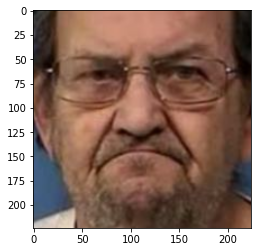

In [14]:
ind=9
for i,j in train_dataset.take(1):
    print(age_dict[np.argmax(j["age"][ind].numpy())])
    print(gender_dict[np.argmax(j["gender"][ind].numpy())])
    print(race_dict[np.argmax(j["race"][ind].numpy())])
    plt.imshow(i.numpy()[ind])
    break

Young Adults(3-39)
Female
Indian


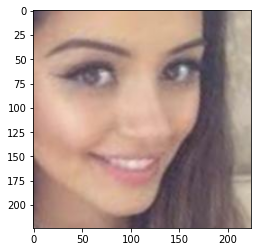

In [15]:
ind=0
for i,j in test_dataset.take(1):
    print(age_dict[np.argmax(j["age"][ind].numpy())])
    print(gender_dict[np.argmax(j["gender"][ind].numpy())])
    print(race_dict[np.argmax(j["race"][ind].numpy())])
    plt.imshow(i.numpy()[ind])
    break
    

In [16]:
#if not one hot
# x_races = list(set(race_train))
# y_races = [race_train.count(i) for i in x_races]
# plt.bar(x_races,y_races)
# plt.show()

In [17]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling=None)

29089792/29084464 [==============================] - 0s 0us/step


In [18]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [19]:
x = base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x) 

In [20]:

x_age=tf.keras.layers.Dropout(0.2)(x)
x_age=tf.keras.layers.Dense(256,activation='relu')(x_age)
x_age=tf.keras.layers.LayerNormalization()(x_age)
x_age=tf.keras.layers.Dropout(0.2)(x_age)
age_pred = tf.keras.layers.Dense  (len(age_dict), activation='softmax', name='age')(x_age) 

x_gender=tf.keras.layers.Dropout(0.2)(x)
x_gender=tf.keras.layers.Dense(256,activation='relu')(x_gender)
x_gender=tf.keras.layers.LayerNormalization()(x_gender)
x_gender=tf.keras.layers.Dropout(0.2)(x_gender)
gender_pred = tf.keras.layers.Dense  (len(gender_dict), activation='softmax', name='gender')(x_gender) 

x_race=tf.keras.layers.Dropout(0.2)(x)
x_race=tf.keras.layers.Dense(256,activation='relu')(x_race)
x_race=tf.keras.layers.LayerNormalization()(x_race)
x_race=tf.keras.layers.Dropout(0.2)(x_race)
race_pred = tf.keras.layers.Dense  (len(race_dict), activation='softmax', name='race')(x_race) 

          

model = tf.keras.models.Model(inputs=base_model.input, outputs=[age_pred,gender_pred,race_pred])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.684342 to fit



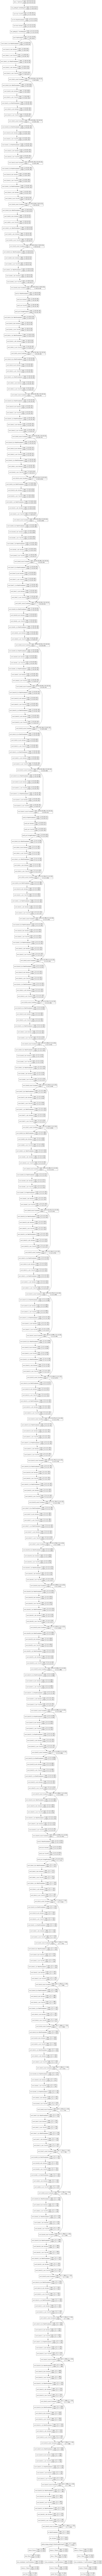

In [21]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True)

In [22]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9

In [23]:
len(model.layers)

443

In [24]:
for layer in model.layers[:-300]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [25]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [26]:
# freq_age_pos, freq_age_neg =compute_class_freqs(tf.keras.backend.one_hot(age_train, len(age_dict)))
freq_age_pos, freq_age_neg =compute_class_freqs(age_train)

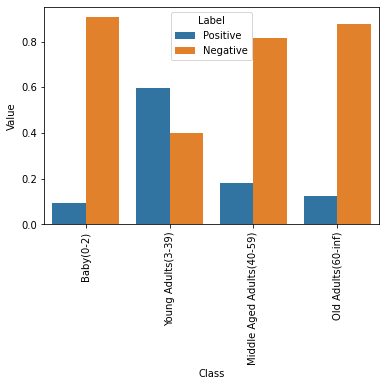

In [27]:
data = pd.DataFrame({"Class": list(age_dict.values()), "Label": "Positive", "Value": freq_age_pos})
data = data.append([{"Class": list(age_dict.values())[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_age_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [28]:
pos_age_weights = freq_age_neg
neg_age_weights = freq_age_pos
pos_age_contribution = freq_age_pos * pos_age_weights 
neg_age_contribution = freq_age_neg * neg_age_weights

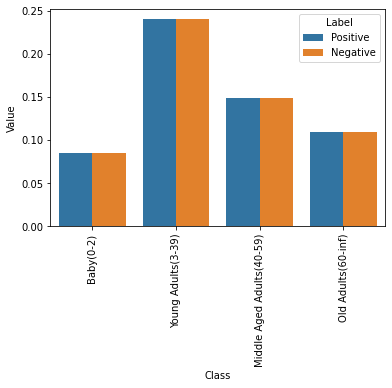

In [29]:

data = pd.DataFrame({"Class": list(age_dict.values()), "Label": "Positive", "Value": pos_age_contribution})
data = data.append([{"Class": list(age_dict.values())[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_age_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [30]:
freq_race_pos, freq_race_neg =compute_class_freqs(race_train)

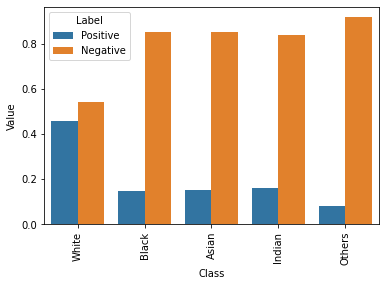

In [31]:
data = pd.DataFrame({"Class": list(race_dict.values()), "Label": "Positive", "Value": freq_race_pos})
data = data.append([{"Class": list(race_dict.values())[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_race_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [32]:
pos_race_weights = freq_race_neg
neg_race_weights = freq_race_pos
pos_race_contribution = freq_race_pos * pos_race_weights 
neg_race_contribution = freq_race_neg * neg_race_weights

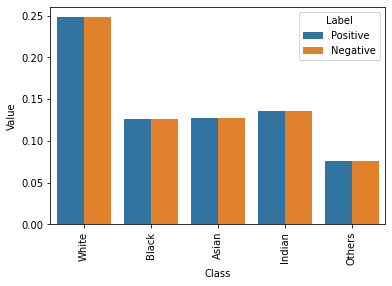

In [33]:

data = pd.DataFrame({"Class": list(race_dict.values()), "Label": "Positive", "Value": pos_race_contribution})
data = data.append([{"Class": list(race_dict.values())[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_race_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [34]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        loss_pos = -1. * K.sum(K.mean(pos_weights * y_true * K.log(y_pred+epsilon), axis=0))
        loss_neg = -1. * K.sum(K.mean(neg_weights * (1 - y_true) * K.log(1-y_pred+epsilon), axis=0))
        return loss_pos+loss_neg
    
        ### END CODE HERE ###
    return weighted_loss

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss={"age":get_weighted_loss(pos_age_weights, neg_age_weights),"race":get_weighted_loss(pos_race_weights, neg_race_weights), "gender":tf.keras.losses.CategoricalCrossentropy()}, metrics=['acc'])

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
import math
from tensorflow.keras.callbacks import LearningRateScheduler

filepath="face_age_race_gender.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.6

    epochs_drop = 8.0


    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))

    return lrate



lrate = LearningRateScheduler(step_decay, verbose=1)
callbacks_list = [checkpoint,lrate]


In [37]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs = 10, callbacks=callbacks_list)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
1842/1842 [==============================] - ETA: 0s - loss: 1.5475 - age_loss: 0.5047 - gender_loss: 0.3273 - race_loss: 0.7154 - age_acc: 0.7404 - gender_acc: 0.8530 - race_acc: 0.7085
Epoch 00001: val_loss improved from inf to 1.01333, saving model to face_age_race_gender.hdf5
1842/1842 [==============================] - 296s 161ms/step - loss: 1.5475 - age_loss: 0.5047 - gender_loss: 0.3273 - race_loss: 0.7154 - age_acc: 0.7404 - gender_acc: 0.8530 - race_acc: 0.7085 - val_loss: 1.0133 - val_age_loss: 0.3673 - val_gender_loss: 0.2082 - val_race_loss: 0.4379 - val_age_acc: 0.8123 - val_gender_acc: 0.9161 - val_race_acc: 0.8342

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/10
1842/1842 [==============================] - ETA: 0s - loss: 1.0102 - age_loss: 0.3575 - gender_loss: 0.1979 - race_loss: 0.4548 - age_acc: 0.8226 - gender_acc: 0.9197 - race_acc: 0.8202
Epoch 00002: 

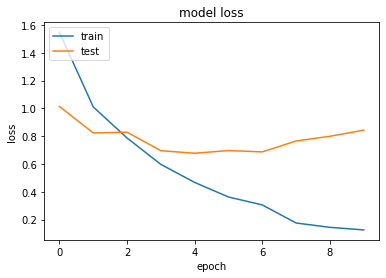

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
model.load_weights("./face_age_race_gender.hdf5")

In [40]:
def pred(ind):
    filename = image_list[ind]
    image_string =tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image[:,:,:3]
    plt.imshow(image.numpy())
    image = tf .expand_dims(image, axis=0)
    preds = model.predict(image)
    age = int(np.argmax(preds[0][0]))
    gender = int(np.argmax(preds[1][0]))
    race = int(np.argmax(preds[2][0]))
    plt.title(f"Title: {filename.split('/')[4]}  Age: {age_dict[age]}  Gender: {gender_dict[gender]}  Race: {race_dict[race]}")
    plt.show()
    

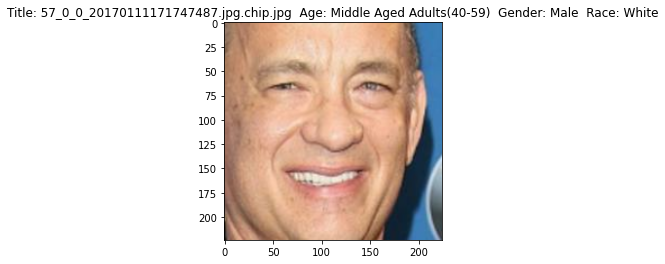

In [41]:
pred(123)  #{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}{0:"Male",1:"Female"}

In [42]:
import numpy as np

random_inds = np.random.randint(len(image_list),size=5)

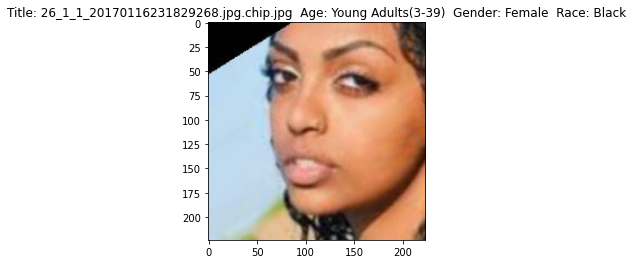

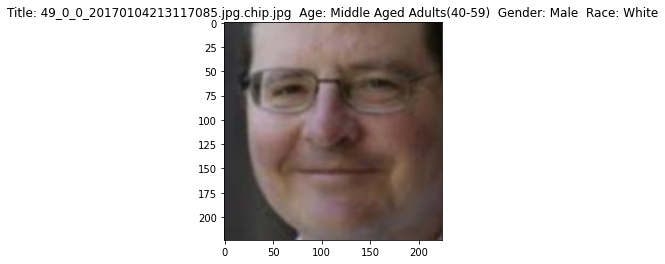

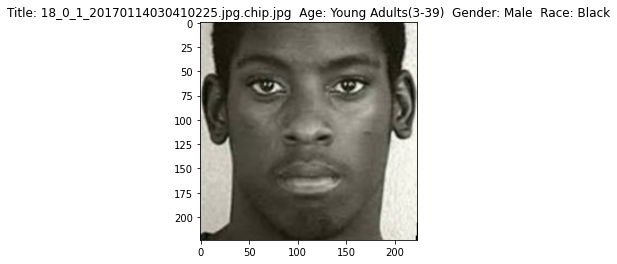

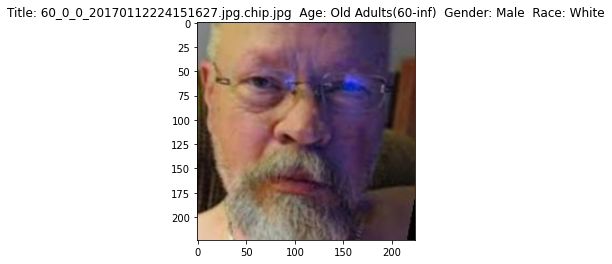

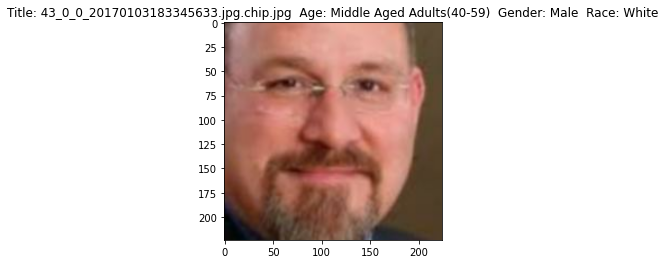

In [43]:
for ind in random_inds:
    pred(ind)